In [2]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

d:\anaconda3\envs\ID2223\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/213141
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
# Create a feature view
wine_fg = fs.get_feature_group(name='wine', version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(
    name='wine_quality',
    version=1,
    description="Read from wine quality dataset",
    labels=["quality"],
    query=query
)

In [5]:
# Split data into train ans test set
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using Hive (6.96s) 


In [6]:
# Train the model using Randomforest
model = DecisionTreeClassifier(criterion='gini')
# model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train.values.ravel())

DecisionTreeClassifier()

In [7]:
y_pred = model.predict(X_test)

metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [9]:
metrics

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5},
 '4': {'precision': 0.13333333333333333,
  'recall': 0.16216216216216217,
  'f1-score': 0.14634146341463417,
  'support': 37},
 '5': {'precision': 0.49266862170087977,
  'recall': 0.4883720930232558,
  'f1-score': 0.4905109489051095,
  'support': 344},
 '6': {'precision': 0.4924731182795699,
  'recall': 0.49567099567099565,
  'f1-score': 0.494066882416397,
  'support': 462},
 '7': {'precision': 0.3389830508474576,
  'recall': 0.3389830508474576,
  'f1-score': 0.3389830508474576,
  'support': 177},
 '8': {'precision': 0.11428571428571428,
  'recall': 0.10256410256410256,
  'f1-score': 0.1081081081081081,
  'support': 39},
 '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1},
 'accuracy': 0.4384976525821596,
 'macro avg': {'precision': 0.2245348340638507,
  'recall': 0.22682177203828197,
  'f1-score': 0.2254300648131009,
  'support': 1065},
 'weighted avg': {'precision': 0.4379258804701785,
  'recal

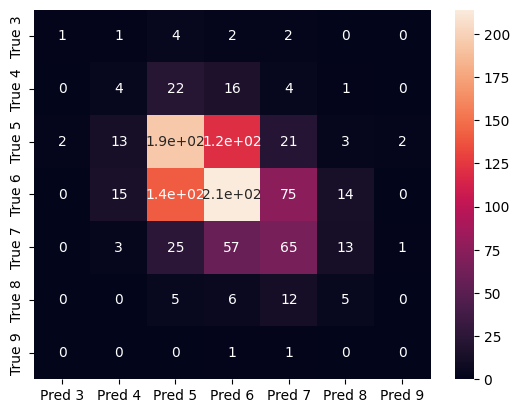

In [71]:
# Createa a confusion matrix as a figure
df_cm = pd.DataFrame(results, 
                    ['True 3', 'True 4', 'True 5', 'True 6', 'True 7', 'True 8', 'True 9'],
                    ['Pred 3', 'Pred 4', 'Pred 5', 'Pred 6', 'Pred 7', 'Pred 8', 'Pred 9'])
cm = sns.heatmap(df_cm, annot = True)
fig = cm.get_figure()
fig.savefig("./confusion_matrix.png")

## Upload model 

In [78]:
mr = project.get_model_registry()

# Create a model dir
model_dir = "wine_model"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save the model
joblib.dump(model, model_dir+'/wine_model.pkl')

# Specifiy the shema of the model's input and output
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model resigtry
wine_model = mr.python.create_model(
    name='wine_model',
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine quality predictor",
)

# Upload the model to model registry
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


ModelRegistryException: Model with name wine_model and version 1 already exists